# Setup enviroment

In [2]:
!pip3 install hiddenlayer > /dev/null
!pip3 install ipdb > /dev/null
import json
import os
import numpy as np
import random
import time

import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.datasets.folder import default_loader
from torchvision.transforms import functional as ft
from torchvision import transforms
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import hiddenlayer as hl

from google.colab import drive

from tqdm.notebook import tqdm

tr.backends.cudnn.deterministic = False
tr.backends.cudnn.benchmark = True

In [3]:
drive.mount('./drive')

Mounted at ./drive


In [4]:
os.chdir("/content/drive/My Drive/Workspace/pic2sgf/training")

# Dataset

In [5]:
class BoardExtractor():
    def __init__(self, size):
        self.size = size
        B = np.array([[8, 8, 1],
                      [self.size-8, 8, 1],
                      [self.size-8, self.size-8, 1],
                      [8, self.size-8, 1]]).T
        self.T2 = np.linalg.inv(B[:, 0:3] * np.linalg.solve(B[:, 0:3], B[:, 3]))

    def __call__(self, img, vertexs):
        A = np.concatenate([vertexs.T, np.array([[1.0, 1.0, 1.0, 1.0]])], axis=0)
        T1 = A[:, 0:3] * np.linalg.solve(A[:, 0:3], A[:, 3])
        T = np.matmul(T1, self.T2)
        T /= T[2,2]
        board = img.transform((self.size, self.size),
                              method=Image.PERSPECTIVE,
                              data = T.reshape(-1),
                              resample=Image.BILINEAR)
        return board.transpose(Image.ROTATE_180)

In [6]:
class ImbalancedDatasetSampler(tr.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.indices = list(range(len(dataset)))
        self.num_samples = len(self.indices)
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self.get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self.get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = tr.DoubleTensor(weights)

    def get_label(self, dataset, idx):
        _, lbl = dataset[idx]
        return lbl
                
    def __iter__(self):
        return (self.indices[i] for i in tr.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [7]:
class BoardSizeDataset(Dataset):
    def __init__(self, metadata_files):
        super(BoardSizeDataset, self).__init__()
        self.classes = [9, 13, 19]
        self.board_extractor = BoardExtractor(192)
        self.size = []
        self.vertexs = []
        self.image = []
        for file in metadata_files:
            with open(file, 'r') as f:
                metadata = json.load(f)
            for entry in tqdm(metadata):
                self.size.append(int(entry['size']))
                img = self.load_image("images/" + entry['filename'])
                vertexs = np.array(entry['corners'])/100
                vertexs[:, 0] *= img.size[0]
                vertexs[:, 1] *= img.size[1]
                self.vertexs.append(self.order_vertexs(vertexs, img.size))
                self.image.append(img)

    def __getitem__(self, i):
        if i >= len(self.image):
            i -= len(self.image)
            lbl = 3
        else:
            lbl = self.classes.index(self.size[i])

        vertexs = self.vertexs[i] + np.random.normal(scale=1, size=(4,2))
        if lbl == 3:
            vertexs[np.random.randint(0, 4)] += np.random.randint(12, 100, size=2) * (2*np.random.binomial([0,1], 0.5)-1)
        
        img = self.board_extractor(self.image[i], vertexs)
        img = ft.adjust_brightness(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_contrast(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_gamma(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        img = ft.adjust_saturation(img, np.clip(np.random.normal(loc=1, scale=0.3), 0.4, 1.6))
        if np.random.binomial(1, 0.5): img = ft.hflip(img)
        if np.random.binomial(1, 0.5): img = ft.vflip(img)
        img = ft.to_tensor(img)
        return img, lbl

    def __len__(self):
      return 2 * len(self.image)

    def load_image(self, filename):
        img = default_loader(filename)
        if img.size[0] > img.size[1]:
            img = img.resize((512, 384), resample=Image.BILINEAR)
        else:
            img = img.resize((384, 512), resample=Image.BILINEAR).transpose(Image.ROTATE_90)
        return img

    def order_vertexs(self, v, img_size):
        w, h = img_size
        vc = v.copy()
        idxs = np.ones(4).astype(int)
        idxs[0] = np.linalg.norm(vc, ord=2, axis=1).argmin()
        vc[idxs[0]] = np.array([float('inf'), float('inf')])

        idxs[1] = np.linalg.norm(vc - np.array([w,0]), ord=2, axis=1).argmin()
        vc[idxs[1]] = np.array([float('inf'), float('inf')])

        idxs[2] = np.linalg.norm(vc - np.array([w,h]), ord=2, axis=1).argmin()
        vc[idxs[2]] = np.array([float('inf'), float('inf')])

        idxs[3] = np.linalg.norm(vc - np.array([0,h]), ord=2, axis=1).argmin()
        vc[idxs[3]] = np.array([float('inf'), float('inf')])

        last_prod = 0
        for i in range(len(v)):
            prev = v[idxs[(i-1)%4]] - v[idxs[i]]
            post = v[idxs[(i+1)%4]] - v[idxs[i]]
            cross_prod = np.cross(post, prev)
            if cross_prod * last_prod < 0:
                idxs[i], idxs[(i+1)%4] = idxs[(i+1)%4].copy(), idxs[i].copy()
                i += 1
            else:
                last_prod = cross_prod
        return v[idxs]

dataset = BoardSizeDataset(['facebook_fixed.json', 'reddit.json', 'metadata.json'])

In [8]:
plt.figure(figsize=(30,30))
for i in range(25):
    plt.subplot(5, 5, i+1)
    index = random.randrange(len(dataset))
    img, lbl = dataset[index]
    plt.imshow(img.squeeze().transpose(0, 2))
    if lbl < 3:
        size = [9, 16, 19][lbl]
        plt.title(f'{size}x{size}')
    else:
        plt.title('Wrong')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Model

In [9]:
class iblock(nn.Module):
    def __init__(self, dims):
        super(iblock, self).__init__()
        self.conv_path = nn.Sequential(nn.BatchNorm2d(dims), nn.GELU(),
                                       nn.Conv2d(dims, dims, kernel_size=3, padding=1),
                                       nn.GELU(), nn.BatchNorm2d(dims),
                                       nn.Conv2d(dims, dims, kernel_size=3, padding=1))
        
    def forward(self, x):
        return x + self.conv_path(x)


class Sizer(nn.Module):
    def __init__(self):
        super(Sizer, self).__init__()
        self.conv_blocks = nn.Sequential(nn.Conv2d(3, 10, kernel_size=2, stride=2), # 96
                                         iblock(10), nn.GELU(), nn.BatchNorm2d(10),
                                         nn.Conv2d(10, 20, kernel_size=2, stride=2), # 48
                                         iblock(20), nn.GELU(), nn.BatchNorm2d(20),
                                         nn.Conv2d(20, 40, kernel_size=2, stride=2), # 24
                                         iblock(40), nn.GELU(), nn.BatchNorm2d(40),
                                         nn.Conv2d(40, 80, kernel_size=2, stride=2), # 12
                                         iblock(80), nn.GELU(), nn.BatchNorm2d(80),
                                         nn.Conv2d(80, 80, kernel_size=2, stride=2), # 6
                                         iblock(80), nn.GELU(), nn.BatchNorm2d(80),
                                         nn.AdaptiveAvgPool2d(1))
        
        self.linear = nn.Sequential(nn.Linear(80, 20), nn.GELU(), nn.BatchNorm1d(20),
                                    nn.Dropout(0.25), nn.Linear(20, 4), nn.Sigmoid())
                                         

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.linear(x.squeeze(3).squeeze(2))
        return x
      
    def load(self, fname):
        self.load_state_dict(tr.load(fname, map_location=lambda storage, loc: storage))

    def save(self, fname):
        tr.save(self.state_dict(), fname)

# Training

In [10]:
model = Sizer().cuda()
hist = hl.History()
canvas = hl.Canvas()

filename = 'sizer_9'

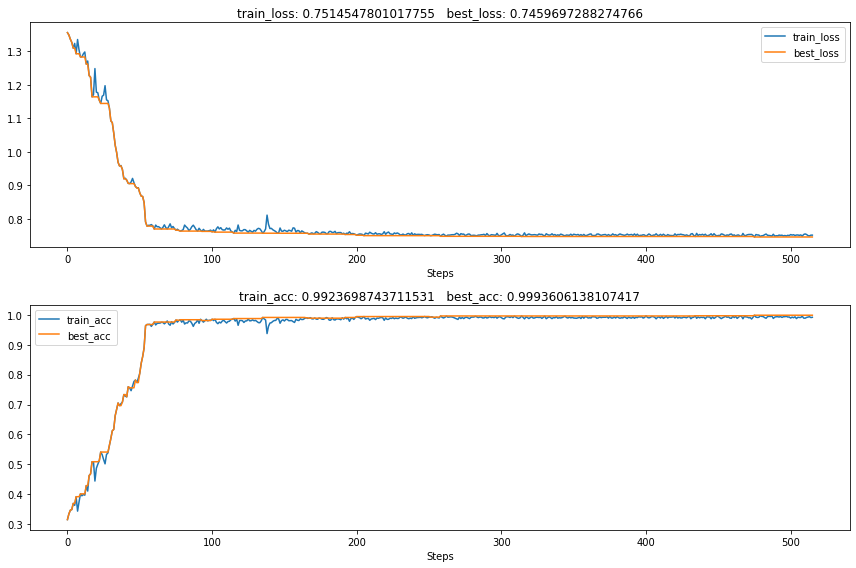

KeyboardInterrupt: ignored

In [11]:
if os.path.isfile('models/' + filename + '.pmt'):
    model.load("models/" + fname + ".pmt")
    hist.load("models/" + fname + ".hist")
    epoch = len(hist['best_total'].data)
    best_loss = min(hist['best_loss'].data)
    best_acc = min(hist['best_acc'].data)
else:
    epoch = len(hist['train_loss'].data)
    best_loss = float('inf')
    best_acc = 0

optimizer = tr.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = tr.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, min_lr=1e-9)

data_sampler = ImbalancedDatasetSampler(dataset)  
data_loader = DataLoader(dataset, batch_size=16, sampler=data_sampler)

# class_weight = np.bincount(np.array(dataset.size))
# class_weight = len(dataset) / class_weight[class_weight > 0]
# class_weight = np.concatenate([class_weight, np.array([1])])
# class_weight /= class_weight.sum()
# loss_func = nn.CrossEntropyLoss(weight=tr.Tensor(class_weight).cuda())

loss_func = nn.CrossEntropyLoss()
        
epochs_without_improvement = 0
while epochs_without_improvement < 200:
    model.train()
    train_loss = 0
    train_acc = 0
    all_preds = []
    all_label = []
    for img, lbl in data_loader:
        img, lbl = img.cuda(), lbl.cuda()
        pred = model(img)

        optimizer.zero_grad()
        loss = loss_func(pred, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.data.item() / len(data_loader)
        all_preds.append(pred.detach().cpu().numpy().argmax(1))
        all_label.append(lbl.detach().cpu().numpy())

    train_acc = balanced_accuracy_score(np.concatenate(all_label), np.concatenate(all_preds))
    scheduler.step(train_loss)

    if train_loss <= best_loss:
        model.save('models/' + filename + ".pmt")
        hist.save('models/' + filename + ".hist")
        best_loss = train_loss
        best_acc = train_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    hist.log(epoch, train_loss=train_loss,
                    best_loss=best_loss,
                    train_acc=train_acc,
                    best_acc=best_acc)

    with canvas:
        canvas.draw_plot([hist["train_loss"],
                          hist["best_loss"]])
        canvas.draw_plot([hist["train_acc"],
                          hist["best_acc"]])
    epoch += 1

hist.summary()

# Test

In [14]:
plt.figure(figsize=(30, 30))
class_name = ["9x9", "13x13", "19x19", "wrong"]

model = Sizer()
model.load('models/' + filename + ".pmt")
model.eval()

for i in range(25):
    plt.subplot(5, 5, i+1)
    index = random.randrange(len(dataset))
    img, lbl = dataset[index]
    pred = model(img.unsqueeze(0)).detach().argmax(1)
    pred = class_name[pred]
    plt.imshow(img.transpose(0,2))
    plt.title(f'Prediction: {pred}')
plt.show()

Output hidden; open in https://colab.research.google.com to view.